## Import libraries and data

In [ ]:
import pandas as pd
import numpy as np
import io #used to read uploaded data
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pylab 
import scipy.stats as stats
import statsmodels.api as sm
from math import pi

from sklearn.preprocessing import LabelEncoder


import seaborn as sns
from sklearn.utils import shuffle
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns', 100)


Just upload these whichever way you want and save as train and tets respectively

In [ ]:
train = pd.read_csv('train.csv', sep = ';')
train['fraud'] = train['fraud'].map({'Y':1,'N':0})
#fraud = train['fraud']

In [ ]:
test = pd.read_csv('test.csv', sep = ';')
ids = test['claim_id']

## Preprocessing Data

In [ ]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop(['fraud','claim_amount'], axis=1) # Remove target value
all_data = all_data.set_index("claim_id")

all_data['num_missing'] = (all_data==-1).sum(axis=1)


# number of delay 
all_data['claim_date_registered'] = pd.to_datetime(all_data['claim_date_registered'], format='%Y%m%d')
all_data['claim_date_occured'] = pd.to_datetime(all_data['claim_date_occured'], format='%Y%m%d')
all_data.loc[:,'num_of_delay_days'] = (all_data.loc[:,'claim_date_registered']- all_data.loc[:,'claim_date_occured'])
all_data.loc[:,'num_of_delay_days'] = all_data.loc[:,'num_of_delay_days']//np.timedelta64(1, 'D')

# alcohol_test
all_data['alcohol_test'] = np.where((all_data['claim_alcohol'] =='P')|(all_data['claim_alcohol'] =='N'), 'Yes', 'No')

# age of vehicle (***used reference year as 2017***)
end = 201712.0
all_data.loc[:,'age_of_vehicle'] = (end - all_data.loc[:,'claim_vehicle_date_inuse'])//100

# age of policyholder (***used reference year as 2017***)
reference_year = 2017.0
all_data.loc[:,'age_of_policyholder'] = (reference_year - all_data.loc[:,'policy_holder_year_birth'])

# expert_appointed (Yes -> if there was an expert appointed by the policyholder)
all_data['expert_appointed'] = np.where(all_data['policy_holder_expert_id'].isna(), 'Yes', 'No')

# age of driver (***used reference year as 2017***)
reference_year = 2017.0
all_data.loc[:,'age_of_driver'] = (reference_year - all_data.loc[:,'driver_year_birth'])

# Number of policy years (expiry date - start date)
all_data['policy_date_start'] = pd.to_datetime(all_data['policy_date_start'], format='%Y%m')
all_data['policy_date_next_expiry'] = pd.to_datetime(all_data['policy_date_next_expiry'], format='%Y%m')
all_data.loc[:,'policy_years'] = all_data.loc[:,'policy_date_next_expiry'] - all_data.loc[:,'policy_date_start']
all_data['policy_years'] = round(all_data['policy_years']/np.timedelta64(1, 'Y'),0)

# Renewed? (Missing -> No)
all_data['renewed'] = np.where(all_data['policy_date_last_renewed'].isna(), 'No', 'Yes')

# Repair performed? (Missing -> No)
all_data['repair_performed'] = np.where(all_data['repair_id'].isna(), 'No', 'Yes')

# third party involved?
all_data['tp_claim'] = np.where(all_data['third_party_1_id'].isna(),'N','Y')
# number of third party involved
a = all_data['third_party_1_id'].notna().astype(int)
b = all_data['third_party_2_id'].notna().astype(int)
c = all_data['third_party_3_id'].notna().astype(int)
all_data['n_tp'] = a + b + c 


all_data['claim_alcohol'].fillna('NA',inplace = True)
all_data['claim_language'].fillna('NA',inplace = True)
all_data['claim_vehicle_type'].fillna('NA',inplace = True)
all_data['claim_vehicle_brand'].fillna('others',inplace = True)
all_data['claim_vehicle_fuel_type'].fillna('NA',inplace = True)
all_data['policy_years'].fillna(0,inplace = True)

# Replacing missing values of claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_power with mean based on type 
all_data["claim_vehicle_cyl"] = all_data.groupby(['claim_vehicle_type'])['claim_vehicle_cyl'].apply(lambda x: x.fillna(x.mean()))
all_data["claim_vehicle_load"] = all_data.groupby(['claim_vehicle_type'])['claim_vehicle_load'].apply(lambda x: x.fillna(x.mean()))
all_data["claim_vehicle_power"] = all_data.groupby(['claim_vehicle_type'])['claim_vehicle_power'].apply(lambda x: x.fillna(x.mean()))

# Replace the age of policyholder by mean (as there are no outliers)
all_data['age_of_policyholder'].fillna(all_data['age_of_policyholder'].mean(),inplace = True)

# Replace the policyholder postal code by mode (we can also delete the rows - only 111 - 0.13%)
all_data['policy_holder_postal_code'].fillna(int(all_data['policy_holder_postal_code'].mode()),inplace = True)

# Replace the driver postal code by mode (we can also delete the rows - only 73 - 0.08%)
all_data['driver_postal_code'].fillna(int(all_data['driver_postal_code'].mode()),inplace = True)

# Replace the age of driver by mean (as there are no outliers)
all_data['age_of_driver'].fillna(all_data['age_of_driver'].mean(),inplace = True)

# Replace policy_premium_100 with mean (no outliers)
all_data['policy_premium_100'].fillna(all_data['policy_premium_100'].mean(),inplace = True)

# Replace policy_coverage_1000 with median (there were outliers)
all_data['policy_coverage_1000'].fillna(all_data['policy_coverage_1000'].median(),inplace = True)

# Replace age_of_vehicle with median (there were outliers)
all_data['age_of_vehicle'].fillna(all_data['age_of_vehicle'].median(),inplace = True)


#convert postal codes to categories
all_data['claim_postal_code'] = all_data['claim_postal_code'].astype(str)
all_data['policy_holder_postal_code'] = all_data['policy_holder_postal_code'].astype(str)

#all_data['driver_postal_code'] = all_data['driver_postal_code'].astype(float)
all_data['driver_postal_code'] = all_data['driver_postal_code'].astype(str)

# deleting columns --> claim_time_occurred(59% of the data missing)
columns_to_drop = ['claim_time_occured','claim_vehicle_date_inuse','policy_holder_expert_id','policy_holder_year_birth','driver_expert_id',
                   'driver_year_birth','driver_vehicle_id','third_party_1_id','third_party_1_form','third_party_1_country',
                  'third_party_1_vehicle_id','third_party_1_expert_id','third_party_2_id','third_party_2_country','third_party_2_form',
                   'third_party_2_vehicle_id','third_party_2_expert_id','third_party_3_id','third_party_3_form','third_party_3_country',
                   'third_party_3_vehicle_id','third_party_3_expert_id','policy_date_start','policy_date_next_expiry','policy_date_last_renewed',
                   'repair_id','repair_postal_code','repair_form','repair_year_birth','repair_country','third_party_1_postal_code','third_party_1_injured','third_party_1_vehicle_type','third_party_1_year_birth','third_party_2_postal_code',
                   'third_party_2_injured','third_party_2_vehicle_type','third_party_2_year_birth','third_party_3_postal_code',
                   'third_party_3_injured','third_party_3_vehicle_type','third_party_3_year_birth','claim_vehicle_id',
                  'policy_holder_id','driver_id','claim_date_registered', 'claim_date_occured',
                  'policy_date_start','policy_date_next_expiry']
all_data = all_data.drop(columns = columns_to_drop,axis =1)

#all_data =  pd.get_dummies(all_data)

all_data.head()

,claim_postal_code,claim_cause,claim_liable,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_police,claim_alcohol,claim_language,claim_vehicle_brand,claim_vehicle_type,claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_fuel_type,claim_vehicle_power,policy_holder_postal_code,policy_holder_form,policy_holder_country,driver_postal_code,driver_form,driver_country,driver_injured,repair_sla,policy_num_changes,policy_num_claims,policy_premium_100,policy_coverage_1000,policy_coverage_type,num_missing,num_of_delay_days,alcohol_test,age_of_vehicle,age_of_policyholder,expert_appointed,age_of_driver,policy_years,renewed,repair_performed,tp_claim,n_tp
claim_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000,2018,traffic accident,Y,1,1,2,Y,NA,2.0,others,car,998.000000,1.250000,1.0,51.000000,2660.0,F,B,2660.0,F,B,N,N,1,0,4.000000,19.0,#000111000,0,3,No,9.0,36.0,Yes,36.0,1.0,Yes,No,Y,1
10001,8820,traffic accident,N,0,0,1,N,NA,2.0,others,car,1527.108556,1.854459,1.0,78.098905,1730.0,M,B,1730.0,M,B,N,Y,0,0,7.995746,19.0,#000000000,0,9,No,3.0,31.0,Yes,31.0,0.0,No,Yes,N,0
10002,1831,traffic accident,Y,0,1,2,N,NA,2.0,TOYOTA,van,3000.000000,3.300000,1.0,175.000000,9200.0,M,B,9200.0,M,B,N,N,0,0,20.000000,58.0,#111110000,0,4,No,13.0,46.0,Yes,46.0,10.0,Yes,No,Y,1
10003,2610,traffic accident,Y,0,1,3,N,NA,2.0,PEUGEOT,car,1868.000000,1.590000,2.0,51.000000,2610.0,M,B,2610.0,M,B,N,N,0,8,4.000000,19.0,#000110000,0,4,No,17.0,72.0,Yes,72.0,19.0,Yes,No,Y,1
10004,1210,traffic accident,Y,0,1,3,N,NA,1.0,MITSUBISHI,car,1499.000000,1.460000,1.0,80.000000,7340.0,F,B,7340.0,M,B,N,N,0,9,19.000000,15.0,#111110110,0,3,No,9.0,33.0,Yes,60.0,11.0,Yes,No,Y,1


## Label Encode the categorical data

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
 
cols = [x for x in all_data.columns if all_data[x].dtype=="object"]
 
 
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Train dataset

In [ ]:
dataset_train = all_data[:train.shape[0]]
dataset_train['fraud'] = train["fraud"].values
dataset_train = dataset_train.loc[dataset_train['age_of_vehicle'] > 0]
dataset_train = dataset_train.loc[dataset_train['age_of_policyholder']<90]
dataset_train = dataset_train.loc[dataset_train['age_of_driver']<90]
trainset = dataset_train.copy()

In [ ]:
trainset = dataset_train.copy()

# Test data set

In [ ]:
dataset_test = all_data[train.shape[0]:all_data.shape[0]]
testset = dataset_test.copy()

In [ ]:
testset = dataset_test.copy()

# Light work

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Feature variables 
X = trainset.drop('fraud', axis=1) 
 
# Target variable
y = trainset['fraud']

In [ ]:
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=123)
#X, y = smote.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
#categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
train_data = lgb.Dataset(X, label=y)
test_data = lgb.Dataset(X_test, label=y_test)

## Bayesian optimization



In [ ]:
 
features = list(trainset)
features.remove('fraud')
target = 'fraud'
 
X = trainset.drop('fraud', axis=1)
y = trainset.fraud
 
smote = SMOTE(random_state=123)
X, y = smote.fit_resample(X, y)
 
def bayes_parameter_opt_lgb(X, y, init_round=50, opt_round=50, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO
    print(lgbBO.max['params'])
    print(lgbBO.res)
    
 
opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 36696, number of negative: 36696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 73392, number of used features: 39
[LightGBM] [Info] Number of positive: 36696, number of negative: 36696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  7        |  0.9939   |  0.8      |  0.9      |  0.0      |  3.0      |  5.34     |  41.98    |  0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  10       |  0.9969   |  0.9175   |  0.2053   |  0.7007   |  0.203    |  8.891    |  41.4     |  0.06127  |  25.83    |
[LightGBM] [Info] Number of positive: 36696, number of negative: 36696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 73392, number of used features: 39
[

|  11       |  0.9979   |  0.8921   |  0.4944   |  4.602    |  1.968    |  8.489    |  41.25    |  0.0351   |  41.18    |
[LightGBM] [Info] Number of positive: 36696, number of negative: 36696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 73392, number of used features: 39
[LightGBM] [Info] Number of positive: 36696, number of negative: 36696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 73392, number of used features: 39
[LightGBM] [Info] Number

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  13       |  0.996    |  0.8      |  0.1      |  5.0      |  0.0      |  8.99     |  37.67    |  0.001    |  41.46    |
[LightGBM] [Info] Number of positive: 36696, number of negative: 36696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3514
[LightGBM] [Info] Number of data points in the train set: 73392, number of used features: 39
[LightGBM] [Info] Number of positive: 36696, number of negative: 36696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010029 seconds.
You can set `force_row_wise=true` to remove the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
params = opt_params.max['params']
params

{'bagging_fraction': 0.8944096048275997,
 'feature_fraction': 0.2570103523346905,
 'lambda_l1': 4.456764583377503,
 'lambda_l2': 2.866091847009541,
 'max_depth': 8.791253279522703,
 'min_child_weight': 39.87770110462892,
 'min_split_gain': 0.030107706144650703,
 'num_leaves': 44.28885912174498}

## Light GMB

In [ ]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'max_bin': 255,
    'metric': 'auc',
    #'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 45,
    #'feature_fraction': 0.1,
    #'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'learning_rate': 0.01,
    'min_data_in_leaf':100,
    'min_child_weight': 5,
    
    'verbose': 0
}
 
model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.886139
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.888083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.886921
[LightGBM] [Warning] No further splits with positive gain,

[127]	valid_0's auc: 0.958825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's auc: 0.959088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's auc: 0.959302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's auc: 0.959477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's auc: 0.959677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's auc: 0.959834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's auc: 0.96001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's auc: 0.960167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's auc: 0.960287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's auc: 0.960514
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's auc: 0.975293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's auc: 0.97546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's auc: 0.975562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's auc: 0.975798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's auc: 0.97593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's auc: 0.976083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's auc: 0.976134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's auc: 0.976205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's auc: 0.976241
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[302]	valid_0's auc: 0.98283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's auc: 0.982916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's auc: 0.983016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[305]	valid_0's auc: 0.983122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	valid_0's auc: 0.983256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's auc: 0.983373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's auc: 0.98345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's auc: 0.9835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's auc: 0.983635
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's auc: 0.988894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[382]	valid_0's auc: 0.98899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's auc: 0.988987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	valid_0's auc: 0.989053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_0's auc: 0.989082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[386]	valid_0's auc: 0.989154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[387]	valid_0's auc: 0.989203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[388]	valid_0's auc: 0.989244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[389]	valid_0's auc: 0.989274
[LightGBM] [Warning] No further splits with positive gai

[464]	valid_0's auc: 0.99279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[465]	valid_0's auc: 0.992806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[466]	valid_0's auc: 0.992852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[467]	valid_0's auc: 0.992882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[468]	valid_0's auc: 0.992914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's auc: 0.992961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's auc: 0.992995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's auc: 0.99304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's auc: 0.993069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's auc: 0.993116
[LightGBM] [Warning] No fur

[545]	valid_0's auc: 0.995341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	valid_0's auc: 0.995353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	valid_0's auc: 0.995387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[548]	valid_0's auc: 0.995402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[549]	valid_0's auc: 0.995418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[550]	valid_0's auc: 0.995451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[551]	valid_0's auc: 0.995479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[552]	valid_0's auc: 0.995499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[553]	valid_0's auc: 0.995521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[554]	valid_0's auc: 0.995547
[LightGBM] [Warning] No f

[636]	valid_0's auc: 0.996973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[637]	valid_0's auc: 0.996989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[638]	valid_0's auc: 0.997012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[639]	valid_0's auc: 0.997021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's auc: 0.997042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[641]	valid_0's auc: 0.997056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[642]	valid_0's auc: 0.997067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's auc: 0.997077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[644]	valid_0's auc: 0.997096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[645]	valid_0's auc: 0.99711
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[726]	valid_0's auc: 0.998195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's auc: 0.998211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's auc: 0.998224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's auc: 0.998233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's auc: 0.998248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's auc: 0.998258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's auc: 0.99827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's auc: 0.998278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's auc: 0.998289
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	valid_0's auc: 0.998824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	valid_0's auc: 0.998833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	valid_0's auc: 0.998846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	valid_0's auc: 0.998856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	valid_0's auc: 0.998852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's auc: 0.99886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's auc: 0.998866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's auc: 0.998877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's auc: 0.998888
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's auc: 0.999273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's auc: 0.999281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	valid_0's auc: 0.999287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's auc: 0.999287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's auc: 0.999287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's auc: 0.999297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's auc: 0.9993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[904]	valid_0's auc: 0.999308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[905]	valid_0's auc: 0.999307
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's auc: 0.999532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's auc: 0.999533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's auc: 0.999535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's auc: 0.999539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's auc: 0.99954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's auc: 0.999541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's auc: 0.999545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's auc: 0.999545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's auc: 0.999548
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1059]	valid_0's auc: 0.999686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1060]	valid_0's auc: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1061]	valid_0's auc: 0.99969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1062]	valid_0's auc: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1063]	valid_0's auc: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1064]	valid_0's auc: 0.999692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1065]	valid_0's auc: 0.999694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1066]	valid_0's auc: 0.999697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1067]	valid_0's auc: 0.999701
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's auc: 0.999805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's auc: 0.999805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's auc: 0.999806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1147]	valid_0's auc: 0.999807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1148]	valid_0's auc: 0.999809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1149]	valid_0's auc: 0.999811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	valid_0's auc: 0.999812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1151]	valid_0's auc: 0.999814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1152]	valid_0's auc: 0.999816
[LightGBM] [Warning] No further splits with po

[1226]	valid_0's auc: 0.999879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1227]	valid_0's auc: 0.999879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1228]	valid_0's auc: 0.999882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1229]	valid_0's auc: 0.999882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1230]	valid_0's auc: 0.999883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1231]	valid_0's auc: 0.999883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1232]	valid_0's auc: 0.999885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1233]	valid_0's auc: 0.999884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1234]	valid_0's auc: 0.999884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1235]	valid_0's auc: 0.999884
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1321]	valid_0's auc: 0.999938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1322]	valid_0's auc: 0.999938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's auc: 0.999938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's auc: 0.999939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's auc: 0.999939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's auc: 0.999939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1327]	valid_0's auc: 0.999941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's auc: 0.999941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1329]	valid_0's auc: 0.999941
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1405]	valid_0's auc: 0.999963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's auc: 0.999961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's auc: 0.999961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's auc: 0.999961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1409]	valid_0's auc: 0.999961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's auc: 0.999961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1411]	valid_0's auc: 0.999962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1412]	valid_0's auc: 0.999962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's auc: 0.999962
[LightGBM] [Warning] No further splits with po

[1490]	valid_0's auc: 0.999972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1491]	valid_0's auc: 0.999973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1492]	valid_0's auc: 0.999974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1493]	valid_0's auc: 0.999974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1494]	valid_0's auc: 0.999974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1495]	valid_0's auc: 0.999974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1496]	valid_0's auc: 0.999974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1497]	valid_0's auc: 0.999974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1498]	valid_0's auc: 0.999974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1499]	valid_0's auc: 0.999974
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1574]	valid_0's auc: 0.999986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1575]	valid_0's auc: 0.999987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1576]	valid_0's auc: 0.999987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1577]	valid_0's auc: 0.999987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1578]	valid_0's auc: 0.999987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1579]	valid_0's auc: 0.999988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1580]	valid_0's auc: 0.999987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1581]	valid_0's auc: 0.999988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1582]	valid_0's auc: 0.999988
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1664]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1665]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1666]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1667]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1668]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1669]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1670]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1671]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1672]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1750]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1751]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1753]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1754]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1755]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1756]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1757]	valid_0's auc: 0.999995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1758]	valid_0's auc: 0.999994
[LightGBM] [Warning] No further splits with po

[1845]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1846]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1847]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1848]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1849]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1850]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1851]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1852]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1853]	valid_0's auc: 0.999996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1854]	valid_0's auc: 0.999996
[LightGBM] [War

[1934]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1935]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1937]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1938]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1939]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1940]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1942]	valid_0's auc: 0.999998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1943]	valid_0's auc: 0.999998
[LightGBM] [War

In [ ]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9996


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[16518     0]
 [    7    81]]

True Positives(TP) =  16518

True Negatives(TN) =  81

False Positives(FP) =  0

False Negatives(FN) =  7


In [ ]:
y_pred_prob = model.predict(testset, num_iteration=model.best_iteration)
best_valid_preds = [np.min(x) for x in y_pred_prob]
best_valid_preds = pd.DataFrame(best_valid_preds)
best_valid_preds['claimID'] = ids
best_valid_preds.columns = ['Prob', 'claim_id']
best_valid_preds = best_valid_preds[['claim_id', 'Prob']]
best_valid_preds.to_csv('assignment1attempt(bestsofar).csv', encoding='utf-8', index=False, header = False)

In [ ]:
best_valid_preds.head()

,claim_id,Prob
0,65469,0.000381
1,65470,0.000216
2,65471,0.000048
3,65472,0.000586
4,65473,0.000208
...,...,...
29950,95422,0.111946
29951,95423,0.018141
29952,95424,0.027208
29953,95425,0.001115


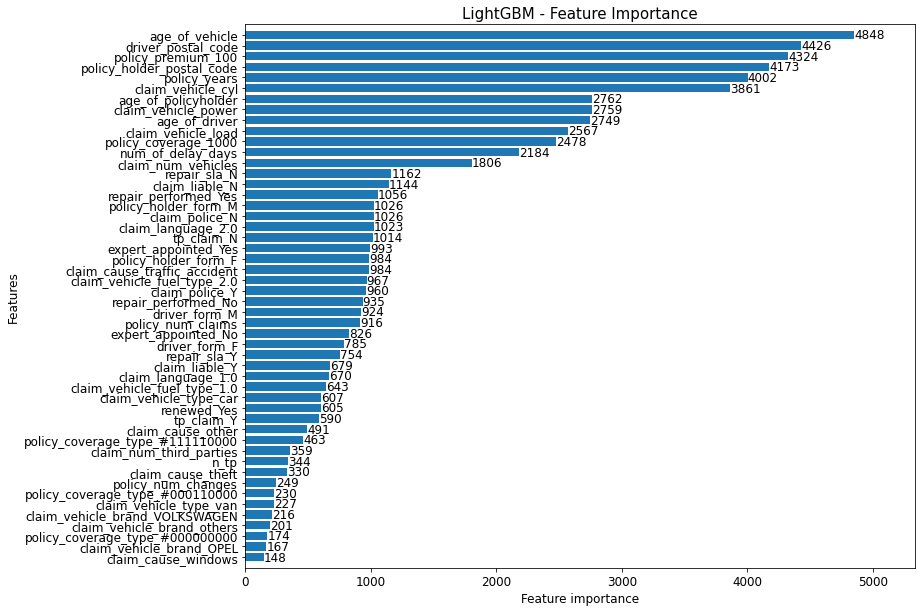

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()